导包

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from imgaug import augmenters as iaa
import imgaug as ia
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import math
import random
import matplotlib.image as mpimg
from PIL import Image
import cv2
from scipy.stats import ks_2samp

# EDA

In [2]:
data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

In [3]:
# 计算数据集大小
dataset_size = len(data)

# 获取所有图像文件名
image_files = data['ImageName'].values

# 计算类别数量
num_classes = data['cellTypeName'].nunique()

# 获取图像尺寸
image_sizes = []
for image_file in image_files:
    image = Image.open("./Image_classification_data/patch_images/" + image_file)
    image_sizes.append(image.size)

# 计算图像尺寸的均值和标准差
mean_image_size = np.mean(image_sizes, axis=0)
std_image_size = np.std(image_sizes, axis=0)

# 输出结果
print(f"Dataset Size: {dataset_size}")
print(f"Number of Categories: {num_classes}")
print(f"Image Size Mean: {mean_image_size}")
print(f"Image Size Standard Deviation: {std_image_size}")


Dataset Size: 9896
Number of Categories: 4
Image Size Mean: [27. 27.]
Image Size Standard Deviation: [0. 0.]


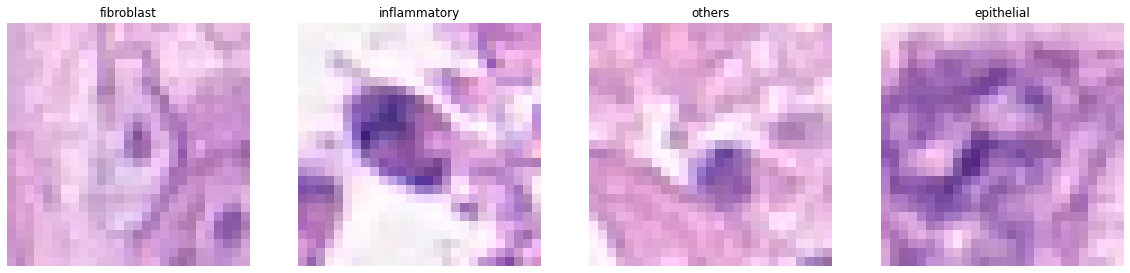

In [4]:
unique_cell_types = data['cellTypeName'].unique()
selected_images = {}

for cell_type in unique_cell_types:
    images_of_cell_type = data[data['cellTypeName'] == cell_type]
    selected_image = images_of_cell_type.sample(n=1).iloc[0]
    selected_images[cell_type] = selected_image['ImageName']

fig, axes = plt.subplots(1, len(unique_cell_types), figsize=(len(unique_cell_types) * 5, 5))

for ax, (cell_type, image_path) in zip(axes, selected_images.items()):
    img = mpimg.imread("./Image_classification_data/patch_images/" + image_path)
    ax.imshow(img)
    ax.set_title(cell_type)
    ax.axis('off')

plt.show()

In [5]:
def visualize_augmentation(image, generator, num_augmented_images=5):
    # 将 PIL.Image 对象转换为 NumPy 数组，并扩展维度以适应 ImageDataGenerator
    image_array = np.expand_dims(np.array(image), axis=0)

    # 使用 ImageDataGenerator 生成增强图像
    augmented_images = generator.flow(image_array, batch_size=1)

    # 绘制原始图像和增强图像
    fig, axes = plt.subplots(1, num_augmented_images + 1, figsize=(15, 15))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    for ax, aug_image in zip(axes[1:], augmented_images):
        ax.imshow(aug_image[0].astype(np.uint8))
        ax.set_title("Augmented Image")
        ax.axis("off")

        num_augmented_images -= 1
        if num_augmented_images == 0:
            break

    plt.show()


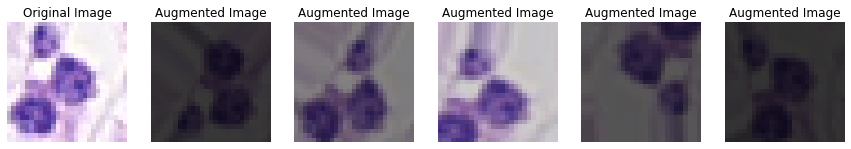

In [6]:
# 随机选择一张图像
selected_image = data.sample(n=1).iloc[0]['ImageName']
image = Image.open("./Image_classification_data/patch_images/" + selected_image)
# 创建 ImageDataGenerator 对象
augmentation_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
# 可视化图像增强效果
visualize_augmentation(image, augmentation_generator)

我们可以从下面的图中发现，`isCancerous`中不会是癌症和是癌症的分布并不相同，即数据不平衡。此外`cellType`也有数据不平衡的问题。

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

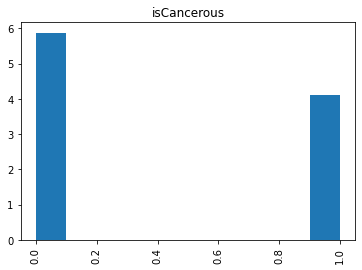

In [7]:
plt.hist(data['isCancerous'], density=True)
plt.title('isCancerous')
plt.xticks(rotation='vertical')

(array([0.63594718, 0.        , 0.        , 0.85657505, 0.        ,
        0.        , 0.4668553 , 0.        , 0.        , 1.37395581]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

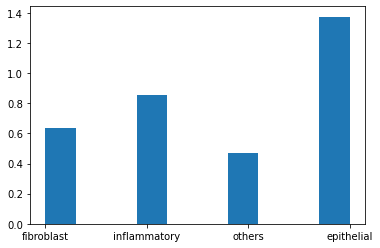

In [8]:
plt.hist(data['cellTypeName'], density=True)

In [9]:
cancer_counts = data.groupby('cellTypeName')['isCancerous'].value_counts().unstack()
cancer_counts.fillna(0, inplace=True)
print(cancer_counts)

isCancerous        0       1
cellTypeName                
epithelial       0.0  4079.0
fibroblast    1888.0     0.0
inflammatory  2543.0     0.0
others        1386.0     0.0


In [10]:
def extract_features(image, extractor):
    # 将图像转换为 OpenCV 格式
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    # 提取图像特征
    keypoints, descriptors = extractor.detectAndCompute(image, None)

    # 将提取的特征展平为一维数组
    if descriptors is not None:
        features = np.mean(descriptors, axis=0)
    else:
        features = np.zeros((extractor.descriptorSize(),))

    return features

In [11]:
# 读取数据
data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

# 获取所有图像文件名
image_files = data['ImageName'].values

# 创建特征提取器
extractor = cv2.ORB_create()

# 计算每个图像的特征
features = []
for image_file in image_files:
    image = Image.open("./Image_classification_data/patch_images/" + image_file)
    feature = extract_features(image, extractor)
    features.append(feature)

# 将特征转换为 NumPy 数组
features = np.array(features)

# 计算特征之间的余弦相似度
similarities = cosine_similarity(features)

# 设置相似度阈值
similarity_threshold = 0.9

# 找到高于阈值的图像对
similar_pairs = np.where(similarities > similarity_threshold)
similar_pairs = [(i, j) for i, j in zip(similar_pairs[0], similar_pairs[1]) if i != j]

# 输出相似图像对
for i, j in similar_pairs:
    print(f"Similar Image Pair: ({image_files[i]}, {image_files[j]})，相似度: {similarities[i, j]:.2f}")

In [4]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# os.environ['TF_DETERMINISTIC_OPS'] = '0'
random.seed(seed_value)
ia.seed(seed_value)

# 数据分割
## 训练集、验证集和测试集
在本项目中，我使用了训练集、验证集和测试集来分割数据。首先，将数据的80%划分为训练集加验证集，剩下的20%划分为不可见测试集。这样的划分方式确保了模型在训练过程中有足够的数据进行学习，从而提高模型的准确性和鲁棒性，防止欠拟合。同时，20%的不可见测试数据作为一个独立的数据集用于评估模型的最终性能，有助于了解模型在未见过的数据上的泛化能力，而不仅仅是模型在训练数据上的拟合程度。

接下来，我将训练集加验证集进一步划分，分为训练集（80%）和验证集（20%）。训练集用于训练模型，验证集对我来说非常重要，它可以反应模型在每轮epoch上的表现，从而更合理的判断模型是否存在过拟合或欠拟合。并我们将根据验证集损失的变化来动态降低学习率。

In [5]:
data['isCancerous'] = data['isCancerous'].astype(str)
data['cellType'] = data['cellType'].astype(str)
undivided_train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(undivided_train_data, test_size=0.2, random_state=42)

### 拆分数据集分布测试
值得注意的是，训练集和测试集应该有相似的分布，保证训练好的模型在测试集上有很好的泛化能力。如果它们的分布不相似，则测试集不能代表训练集，在测试集上获得的性能指标可能无法真实反映模型在实际应用中的性能。这可能会导致对模型性能的误判。我进行了 Kolmogorov-Smirnov (KS) 测试，通过比较训练集和测试集的每一列来评估它们分布的相似性。零假设声明训练集和测试集的每一列具有相同的分布。如果 p 值小于所选的显着性水平 (0.05)，我们可以拒绝原假设，表明分布存在显着差异。同样，检查训练集和未拆分数据集的分布也很重要。这可以帮助我们确保训练集代表未拆分数据集，并有助于识别训练集和未拆分数据集之间是否存在任何偏差。因此，我还对训练集和未拆分数据集进行了 KS 测试。

In [26]:
def is_same_distribution(datasets_a, datasets_b):
    alpha = 0.05
    p_value_map = dict()
    for column in datasets_a.columns:
        _, p_value = ks_2samp(datasets_a[column], datasets_b[column])
        p_value_map[column] = p_value

    columns_with_p_value_less_than_005 = []
    for column, p_value in p_value_map.items():
        if p_value < alpha:
            columns_with_p_value_less_than_005.append(column)
    return len(columns_with_p_value_less_than_005) == 0, columns_with_p_value_less_than_005

# Make sure the distribution of the training set and the test set are the same
is_same, diff_columns = is_same_distribution(train_data, test_data)
if is_same:
    print("The null hypothesis is accepted for the distribution of both the train set and the test set.")
else:
    print("Columns with p-value less than 0.05:", diff_columns)
    print("It is recommended to replace the seed value")

# Make sure the distribution of the training set and the test set are the same
is_same, diff_columns = is_same_distribution(train_data, val_data)
if is_same:
    print("The null hypothesis is accepted for the distribution of both the train set and the validation set.")
else:
    print("Columns with p-value less than 0.05:", diff_columns)
    print("It is recommended to replace the seed value")

# Make sure the distribution of the training set and the overall dataset are the same
is_same, diff_columns = is_same_distribution(train_data, data)
if is_same:
    print("The null hypothesis is accepted for the distribution of both the train set and the entire dataset.")
else:
    print("Columns with p-value less than 0.05:", diff_columns)
    print("It is recommended to replace the seed value")

The null hypothesis is accepted for the distribution of both the train set and the test set.
The null hypothesis is accepted for the distribution of both the train set and the validation set.
The null hypothesis is accepted for the distribution of both the train set and the entire dataset.


### 检查训练集、验证集和测试集的数据分布 Histograms showing the distribution of the training set, validation set, test set, and overall dataset
我们从下面的图可以看出训练集、验证集和测试集的数据分布相近。这有助于确保模型在各个数据集上表现稳定，并且有较好的泛化能力。当训练、验证和测试数据具有相似的分布时，模型更容易从训练集中学习到的模式在验证集和测试集上得到验证，从而提高模型在未知数据上的预测性能。这也有助于我们更准确地评估模型的性能，避免由于数据分布不一致导致的性能差异。

Text(0.5, 1.0, 'cellType')

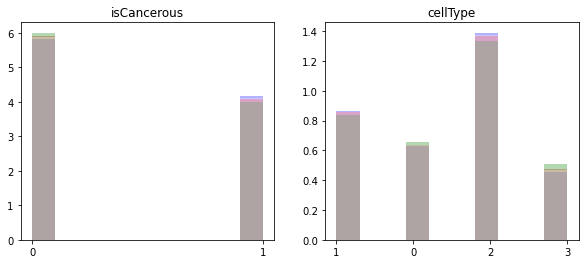

In [28]:
_, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(train_data['isCancerous'], alpha=0.3, color='b', label='Train', density=True)
axes[0].hist(val_data['isCancerous'], alpha=0.3, color='r', label='validation', density=True)
axes[0].hist(test_data['isCancerous'], alpha=0.3, color='g', label='Test', density=True)
axes[0].hist(data['isCancerous'], alpha=0.3, color='w', label='overall',  density=True)
axes[0].set_title('isCancerous')
axes[1].hist(train_data['cellType'], alpha=0.3, color='b', label='Train', density=True)
axes[1].hist(val_data['cellType'], alpha=0.3, color='r', label='validation', density=True)
axes[1].hist(test_data['cellType'], alpha=0.3, color='g',label='Test', density=True)
axes[1].hist(data['cellType'], alpha=0.3, color='w', label='overall',  density=True)
axes[1].set_title('cellType')

### Leakage test
此外，我们需要确保训练集和测试集之间没有重叠样本。这是因为重叠样本会导致数据泄漏，当模型在训练过程中无意中访问了测试集中的信息时，就会发生这种情况。当发生数据泄漏时，模型在训练过程中可能会过度拟合某些测试集数据，从而导致在测试集上表现看似出色。然而，这种过于乐观的表现可能无法准确反映模型处理现实世界未知数据的能力，导致在实际应用中表现不佳。

In [29]:
combined_df = pd.concat([train_data, test_data], axis=0, ignore_index=True)
duplicated_rows = combined_df.duplicated()
if duplicated_rows.any():
    print("The training set and the test set have the same instances: ", combined_df[duplicated_rows])
else:
    print("The training set and the test set do not have the same instances")

The training set and the test set do not have the same instances


---
## 分配类别权重
正如上面所说，由于类别的分布不同所以我们将在后面的改进模型中添加权重，从而降低不平衡数据带来的影响。对于基线模型来说，我们将不使用权重。因为我们想看到没有类别权重时模型的原始性能。然后在增强的模型中观察添加类别权重后模型性能的提升情况。

In [6]:
class_samples_isCancerous = train_data['isCancerous'].value_counts()
total_samples = np.sum(class_samples_isCancerous)
class_weights_isCancerous = total_samples / class_samples_isCancerous
class_weight_dict_isCancerous = {int(k): v for k, v in class_weights_isCancerous.to_dict().items()}

class_samples_cellType = train_data['cellType'].value_counts()
total_samples = np.sum(class_samples_cellType)
class_weights_cellType = total_samples / class_samples_cellType
class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}

---
# Preparing Data Generators for the Baseline Model
下面的代码片段为我们的基线模型准备了数据生成器。数据生成器用于批量加载和预处理图像，使它们准备好输入模型进行训练、验证和测试。此外，对于接下来的验证集和测试集的数据生成器也会被适用于改进模型，因为他们不需要进行额外的图像增强。

我们使用 Keras 的 ImageDataGenerator 类，它使我们能够高效地从磁盘加载图像并应用实时数据增强。然而，在这种情况下，我们只将图像的像素值从范围 [0, 255] 重新缩放到范围 [0, 1]。这种归一化有助于提高神经网络的性能和稳定性。当然，对于不可见的测试集和验证集，同样需要进行图像归一化处理，这是因为测试集也是用来评估模型的性能，与训练集和验证集一样，需要使用相同的预处理方法，以确保测试结果的准确性和可比性。对于批大小，它是我们调节的超参数，并且我们将32作为我们的最终大小。我们也尝试了其他的超参数，即使更大的超参数带来了更快的训练速度，但模型的性能出现了一定程度的下降。更小的批大小也没有带来更好的模型性能。

接下来，我们使用 ImageDataGenerator 的 flow_from_dataframe 方法直接从指定目录读取图像，在本例中为 `./Image_classification_data/patch_images`。它使用之前创建的数据框来获取图像文件名（来自`ImageName`列）及其相应的标签（来自`isCancerous`和`cellType`列）。

`flow_from_dataframe` 函数中的 `class_mode` 参数在读取`isCancerous`标签时设置为`binary`，在读取`cellType`标签时设置为`categorical`，因为`isCancerous`是一个二元分类任务，而`cellType`是一个多类分类任务。重要的是，`categorical`模式将自动将标签进行独热编码，这对多类分类任务是必需的。

训练集数据生成器`train_isCancerous_generator`和`train_cellType_generator`将专门用于基线模型。稍后，我们将为改进的模型创建新的数据生成器，我们将在其中应用更复杂的数据增强技术来进一步提高模型的性能。从而比较进行复杂的数据增强技术的图像和只进行归一化的图像对模型带来的性能改善。

In [7]:
batch_size = 32
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_isCancerous_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

val_isCancerous_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

test_isCancerous_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

train_cellType_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

val_cellType_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

test_cellType_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 6332 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.
Found 6332 validated image filenames belonging to 4 classes.
Found 1584 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


---
# Performance evaluation methods
In this project, the performance of multiple models was evaluated using several widely adopted classification metrics, including cross-entropy loss, accuracy, precision, recall, and F1 score. These metrics were employed to compare the performance differences between the models.

Cross-Entropy Loss is a commonly used metric for classification tasks that measures the difference between the predicted probability distribution and the true distribution of the target variable. A lower cross-entropy loss value indicates higher prediction accuracy. However, this metric alone might not be sufficient to understand the model's performance in all aspects, especially when dealing with imbalanced or multi-category datasets.

Accuracy is the ratio of the number of correct predictions to the total number of predictions made by the model. While accuracy can provide a general sense of the model's performance, it might not be as informative for imbalanced datasets or multi-category classification tasks.

Precision is a measure of the model's ability to correctly identify positive instances, defined as the ratio of true positives to the sum of true positives and false positives. Recall is a measure of the model's ability to identify all positive instances, defined as the ratio of true positives to the sum of true positives and false negatives. The F1 Score is the harmonic mean of precision and recall, providing a balanced evaluation of both the model's ability to identify positive instances and its ability to identify all positive instances.

The custom F1-score class was implemented to calculate the F1 score for multi-category classification tasks, as the TensorFlow framework itself does not have a built-in multi-class F1-score. Multi-Precision is a custom metric derived from the F1-score class, which calculates the average precision across all categories. Multi-Recall is another custom metric derived from the Multi-Category F1 Score class, which calculates the average recall across all categories. The custom Multi-Category F1 Score is a harmonic mean of multi-precision and multi-recall, providing a balanced evaluation of both the model's ability to identify positive instances and its ability to identify all positive instances across multiple categories. Like multi-precision and multi-recall, the multi-category F1 score can be calculated as micro, macro, or weighted, with macro being used by default.

ROC：TODO

In conclusion, by using accuracy alongside cross-entropy loss and the metrics of precision, recall, and F1 score, we can gain a more complete picture of the performance of the models, allowing for a more comprehensive comparison of the differences between models. These metrics are particularly valuable for both binary and multi-category classification tasks, where a single metric might not capture all relevant aspects of the model's performance.

In [8]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_states()
        self.recall.reset_states()

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class MultiCategoryF1Score(tf.keras.metrics.Metric):
    def __init__(self, num_category=4, average='macro', name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_category
        self.average = average
        self.confusion_matrix = self.add_weight(name="confusion_matrix", shape=(num_classes, num_classes), initializer="zeros", dtype=tf.float32)


    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        current_confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, dtype=tf.float32)
        self.confusion_matrix.assign_add(current_confusion_matrix)

    def result(self):
        tp = tf.linalg.diag_part(self.confusion_matrix)
        fp = tf.reduce_sum(self.confusion_matrix, axis=0) - tp
        fn = tf.reduce_sum(self.confusion_matrix, axis=1) - tp

        precision_per_class = tp / (tp + fp + tf.keras.backend.epsilon())
        recall_per_class = tp / (tp + fn + tf.keras.backend.epsilon())

        if self.average == 'micro':
            precision = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fp))
            recall = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fn))
        elif self.average == 'macro':
            precision = tf.reduce_mean(precision_per_class)
            recall = tf.reduce_mean(recall_per_class)
        elif self.average == 'weighted':
            weights = tf.reduce_sum(self.confusion_matrix, axis=1)
            precision = tf.reduce_sum(precision_per_class * weights) / tf.reduce_sum(weights)
            recall = tf.reduce_sum(recall_per_class * weights) / tf.reduce_sum(weights)
        else:
            raise ValueError("Invalid average type. Accepted values are: 'micro', 'macro', 'weighted'")

        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.confusion_matrix.assign(tf.zeros_like(self.confusion_matrix))

    def get_config(self):
        config = super().get_config()
        config.update({"num_classes": self.num_classes, "average": self.average})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class MultiPrecision(MultiCategoryF1Score):
    def __init__(self, num_category=4, average='macro', name='precision', **kwargs):
        super().__init__(num_category, average, name, **kwargs)

    def result(self):
        tp = tf.linalg.diag_part(self.confusion_matrix)
        fp = tf.reduce_sum(self.confusion_matrix, axis=0) - tp
        precision_per_class = tp / (tp + fp + tf.keras.backend.epsilon())
        if self.average == 'micro':
            precision = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fp))
        elif self.average == 'macro':
            precision = tf.reduce_mean(precision_per_class)
        elif self.average == 'weighted':
            weights = tf.reduce_sum(self.confusion_matrix, axis=1)
            precision = tf.reduce_sum(precision_per_class * weights) / tf.reduce_sum(weights)
        else:
            raise ValueError("Invalid average type. Accepted values are: 'micro', 'macro', 'weighted'")
        return precision


class MultiRecall(MultiCategoryF1Score):
    def __init__(self, num_category=4, average='macro', name='recall', **kwargs):
        super().__init__(num_category, average, name, **kwargs)

    def result(self):
        tp = tf.linalg.diag_part(self.confusion_matrix)
        fn = tf.reduce_sum(self.confusion_matrix, axis=1) - tp
        recall_per_class = tp / (tp + fn + tf.keras.backend.epsilon())
        if self.average == 'micro':
            recall = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fn))
        elif self.average == 'macro':
            recall = tf.reduce_mean(recall_per_class)
        elif self.average == 'weighted':
            weights = tf.reduce_sum(self.confusion_matrix, axis=1)
            recall = tf.reduce_sum(recall_per_class * weights) / tf.reduce_sum(weights)
        else:
            raise ValueError("Invalid average type. Accepted values are: 'micro', 'macro', 'weighted'")
        return recall

# def false_positive_rate(y_true, y_pred):
#     false_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * (1 - y_pred), 0, 1)))
#     possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
#     return false_positives / (possible_positives + tf.keras.backend.epsilon())
#
# def true_positive_rate(y_true, y_pred):
#     true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
#     possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
#     return true_positives / (possible_positives + tf.keras.backend.epsilon())

---
# 模型实现
在这个任务中，我们需要对两个值进行预测，一个是判断细胞图像是否为癌细胞，另一个是判断细胞类型，即分类任务。我将使用人工神经网络对其进行建模。根据作业要求，我将使用简单的MLP作为基线模型并且卷积神经网络作为我提升模型的。

## 二分类任务MLP基线模型
在这个任务中，我们需要预测图像是否为癌症，即目标值是二分的。我将使用简单的Multilayer perceptron (MLP)模型对其进行建模，从而确定模型存在的局限以及比较与改进模型之间的性能差异。MLP是一种人工神经网络，它由多层的感知器或神经元组成，每层都全连接到下一层。这些层通常分为三种，输入层、隐藏层和输出层。

我们可以从下面的模型首先对图像进行简单的预处理。由于MLP模型不能直接处理图像数据，我们需要将其转化为一维向量。接下来是隐藏层，我们可以根据问题的复杂性选择多个隐藏层，每层有不同数量的神经元。最后是输出层，由于我们的任务是二分类，所以输出层只有一个神经元。它将输出一个值，表示图像为癌症的概率。

根据作业要求，我们不仅需要完成基线模型而且还尝试使用其他技术来构建改进模型。基线模型将用于与改进模型进行比较从而观察模型性能的差异。

由于我们是二分类任务所以我们使用binary crossentropy loss 函数。

### Problem formulation
对于该任务损失函数使用二元交叉熵 (binary cross entropy)，则目标函数可以表示为：

$$\min_{h \in \mathcal{H}} \frac{1}{n} \sum_{i=1}^{n} -[y_i \log(h(\mathbf{x}_i)) + (1-y_i) \log(1-h(\mathbf{x}_i))]$$

这里 $\mathcal{H}$ 是假设空间，是所有可能的 MLP 函数的集合，其中 $h(\mathbf{x}_i)$ 是 MLP 对于输入 $\mathbf{x}_i$ 的预测值，$y_i$ 是真实标签（0 或 1）。

对于假设空间$\mathcal{H}$ ，由于 MLP 涉及到更复杂的函数形式，所以我把 $\mathcal{H}$ 看作是由所有可能的 MLP 模型（具有各种可能的参数、层数和节点数）构成的函数空间。

### 模型描述
对于判断是否为癌症的二分类任务。输入层将输入图像展平为一个一维张量，尺寸为 (27, 27, 3)。之后进入全连接层：包含 512 个神经元，使用 ReLU 激活函数。输出层：包含 1 个神经元，使用 Sigmoid 激活函数来得到癌症分类的概率。由于我们现在构建简单的基线模型所以我们将使用一层隐藏层。隐藏层的感知器数量为512。值得注意的是隐藏层的感知器数量和层数以及激活函数的选择都是需要调整的超参数。`自动化调参等回复`。对于27x27x3的图像，输入层有2187个神经元。在这种情况下，使用512个神经元的隐藏层我们认为是一个合理的选择。这个数目足够大，能够学习到输入数据中的复杂模式，同时也足够小，以降低过度拟合的风险。此外，512是2的9次方，对于许多深度学习框架来说，使用2的幂作为层的大小可以提高计算效率。

In [9]:
input_shape = (27, 27, 3)
baseline_binary = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
baseline_binary.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 512)               1120256   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,120,769
Trainable params: 1,120,769
Non-trainable params: 0
_________________________________________________________________


In [14]:
baseline_binary.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                        metrics=['accuracy',
                                 tf.keras.metrics.Precision(name='precision'),
                                 tf.keras.metrics.Recall(name='recall'),
                                 F1Score()])

In [15]:
epochs = 100
history_baseline_binary = baseline_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_isCancerous_generator,
    validation_steps=len(val_data) // batch_size
)

Epoch 1/100
197/197 [==============================] - 4s 16ms/step - loss: 0.5228 - accuracy: 0.7470 - precision: 0.7499 - recall: 0.5900 - f1_score: 0.6604 - false_positive_rate: 0.4166 - true_positive_rate: 0.5834 - val_loss: 0.4423 - val_accuracy: 0.8246 - val_precision: 0.7351 - val_recall: 0.8978 - val_f1_score: 0.8084 - val_false_positive_rate: 0.1009 - val_true_positive_rate: 0.8991
Epoch 2/100
197/197 [==============================] - 3s 14ms/step - loss: 0.3821 - accuracy: 0.8487 - precision: 0.8355 - recall: 0.7939 - f1_score: 0.8142 - false_positive_rate: 0.2067 - true_positive_rate: 0.7933 - val_loss: 0.4105 - val_accuracy: 0.7946 - val_precision: 0.9010 - val_recall: 0.5635 - val_f1_score: 0.6933 - val_false_positive_rate: 0.4313 - val_true_positive_rate: 0.5687
Epoch 3/100
197/197 [==============================] - 3s 14ms/step - loss: 0.3537 - accuracy: 0.8530 - precision: 0.8346 - recall: 0.8073 - f1_score: 0.8208 - false_positive_rate: 0.1898 - true_positive_rate: 0.

可视化训练过程

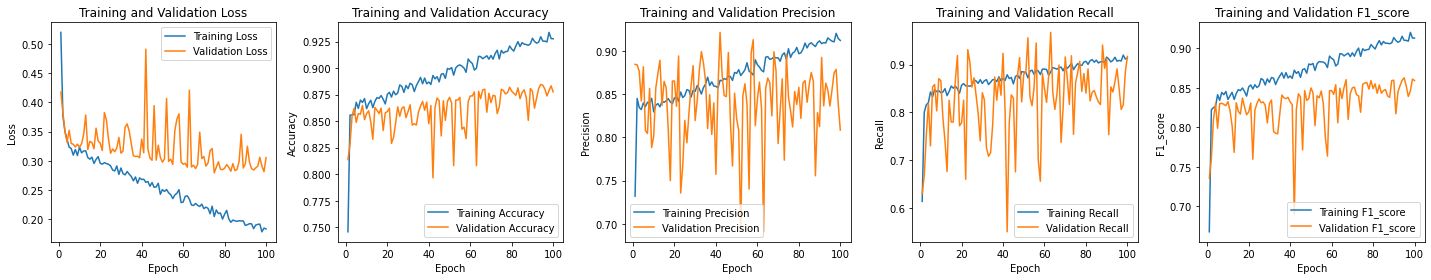

In [13]:
epochs_range = range(1, epochs + 1)
metrics = [key for key in history_baseline_binary.history.keys() if not key.startswith("val_")]
_, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, metric in enumerate(metrics):
    col = idx
    axes[col].plot(epochs_range, history_baseline_binary.history[metric], label=f'Training {metric.capitalize()}')
    axes[col].plot(epochs_range, history_baseline_binary.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
    axes[col].legend()
    axes[col].set_title(f'Training and Validation {metric.capitalize()}')
    axes[col].set_xlabel('Epoch')
    axes[col].set_ylabel(metric.capitalize())
plt.tight_layout()
plt.show()

在不可见数据集上的表现

In [16]:
result = baseline_binary.evaluate(test_isCancerous_generator)

62/62 [==============================] - 1s 11ms/step - loss: 0.2687 - accuracy: 0.8899 - precision: 0.8481 - recall: 0.8824 - f1_score: 0.8649 - false_positive_rate: 0.1167 - true_positive_rate: 0.8833


In [21]:
# y_true = test_isCancerous_generator.classes
# y_pred = baseline_binary.predict(test_isCancerous_generator)
# fpr = result[-2]
# tpr =  result[-1]
#
# plt.plot(result[-2], result[-1], label='ROC curve (area = %0.2f)' % auc)
# plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

62/62 [==============================] - 0s 3ms/step


TypeError: Expected sequence or array-like, got <class 'float'>

### 总结模型性能
根据给出的性能指标，我们可以对模型的性能进行如下分析：
二分类基线模型似乎在训练集上表现良好，准确性、精确度、召回率和 F1 分数都相对较高。但是，还必须考虑验证集的结果，以查看二分类基线模型是否能够很好地泛化到未见数据。
然而，训练和验证结果之间似乎存在明显的差距，这是过度拟合的迹象。二分类基线可能对训练数据的学习太好，因此无法推广到新的、看不见的数据。
此外，另一个潜在的问题是模型的查全率（recall）和查准率（precision）在训练和验证阶段都表现非常不稳定。这可能表明模型在分类正例和反例时可能存在困难，这说明仍需要进一步优化以提高其泛化能力和收敛稳定性。
我们还注意到验证集的损失似乎在波动并且没有显示出一致的下降趋势，这又可能表明过度拟合并且后期的的学习率可能需要调整。

`更大的问题冲ROC曲线中得到反映。从图中我们可以看出曲线与对角线重叠，这说明二分类基线模型的预测能力等同于随机猜测。这是非常糟糕的表现。`

### Improvement
这里我们将在前面所有内容的基础上总结一下对Baseline模型可能改进的探索。首先根据EDA我们发现了数据不平衡的问题，之后我们在分割数据的部分我通过分配类别权重来抑制不平衡数据集的影响。其次，根据我们基线模型的表现，我们发现了模型是过拟合的，它无法在验证集和不可见测试集上体现出泛化能力。因此，我们需要通过改进模型中添加正则化以及Dropout层来解决过拟合的问题。并且批归一化层也会被使用，它同样可以增加模型的泛化能力的同时加速模型收敛速度。同时，我们将在提升模型中使用图像增强技术，这项技术可以增多训练数据从而降低过拟合的风险。第三，我们还发现基线模型收敛并不稳定，所以我们将在改进模型中根据验证集损失值的变化动态降低学习率，从而保证模型稳定的收敛。

## 多分类任务MLP基线模型
在这个任务中，我们需要预测细胞图像的类别，即目标值是多分类问题。我们仍然使用简单的MLP模型作为基线模型。与二分类的MLP模型相比，多分类的MLP模型区别在于输出层的激活函数从sigmoid改为softmax，其余保持不变。值得注意的是我们将改变我们的损失函数从binary crossentropy loss 函数改为 categorical crossentropy函数。因此我们的目标函数也需要进行改变。

### Problem formulation
对于使用多层感知器 (MLP) 进行多分类任务，损失函数使用多类别交叉熵 (categorical crossentropy)，其目标函数可以表示为：

$$\min_{h \in \mathcal{H}} \frac{1}{n} \sum_{i=1}^{n} \left(-\sum_{c=1}^{C} y_{ic} \log(h_{ic}(\mathbf{x}_i))\right)$$

这里 $\mathcal{H}$ 是假设空间，是所有可能的 MLP 函数的集合，其中 $h_{ic}(\mathbf{x}_i)$ 是 MLP 对于输入 $\mathbf{x}_i$ 的预测值（在类别 $c$ 上的预测概率），$y_{ic}$ 是真实标签的 one-hot 编码（对应类别 $c$ 的值）。

对于假设空间，与上文的解释一样，$\mathcal{H}$ 可以被认为是所有可能的 MLP 模型（具有各种可能的参数、层数和节点数）构成的函数空间。

### 模型描述
该模型结构于二分类模型基本一致。
`自动化调参等回复`。对于27x27x3的图像，输入层有2187个神经元。在这种情况下，使用512个神经元的隐藏层我们认为是一个合理的选择。这个数目足够大，能够学习到输入数据中的复杂模式，同时也足够小，以降低过度拟合的风险。此外，512是2的9次方，对于许多深度学习框架来说，使用2的幂作为层的大小可以提高计算效率。

In [ ]:
num_classes = 4
baseline_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
baseline_categorical.compile(loss='categorical_crossentropy',
                             optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00015),
                             metrics=['accuracy',
                                      MultiPrecision(),
                                      MultiRecall(),
                                      MultiCategoryF1Score(num_category=4)])

In [24]:
epochs = 100
history_baseline_categorical = baseline_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_cellType_generator,
    validation_steps=len(val_data) // batch_size
)

Epoch 1/100
197/197 [==============================] - 5s 25ms/step - loss: 1.1957 - accuracy: 0.5370 - precision: 0.4221 - recall: 0.4192 - f1_score: 0.4206 - val_loss: 0.9858 - val_accuracy: 0.6122 - val_precision: 0.4382 - val_recall: 0.4803 - val_f1_score: 0.4583
Epoch 2/100
197/197 [==============================] - 4s 22ms/step - loss: 0.9312 - accuracy: 0.6281 - precision: 0.5213 - recall: 0.5115 - f1_score: 0.5164 - val_loss: 0.8663 - val_accuracy: 0.6658 - val_precision: 0.4774 - val_recall: 0.5473 - val_f1_score: 0.5100
Epoch 3/100
197/197 [==============================] - 4s 23ms/step - loss: 0.8514 - accuracy: 0.6708 - precision: 0.5826 - recall: 0.5595 - f1_score: 0.5708 - val_loss: 1.0339 - val_accuracy: 0.5969 - val_precision: 0.5636 - val_recall: 0.5592 - val_f1_score: 0.5614
Epoch 4/100
197/197 [==============================] - 4s 23ms/step - loss: 0.8551 - accuracy: 0.6575 - precision: 0.5580 - recall: 0.5491 - f1_score: 0.5535 - val_loss: 0.8642 - val_accuracy: 0.6

可视化训练过程

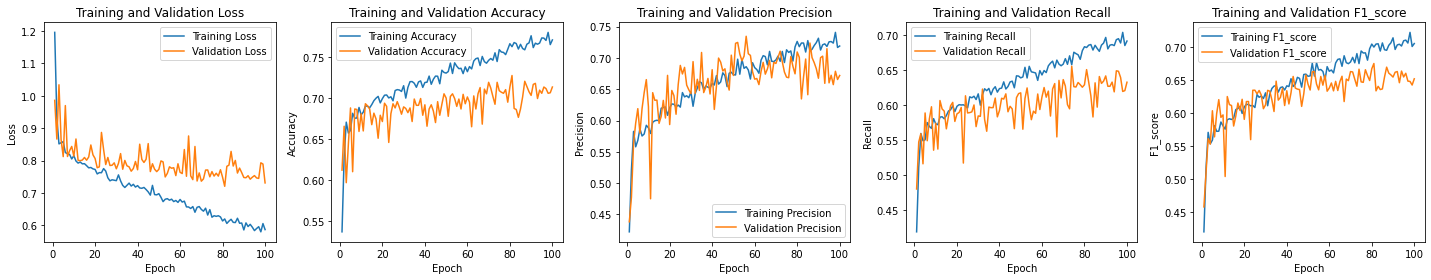

In [25]:
epochs_range = range(1, epochs + 1)
metrics = [key for key in history_baseline_categorical.history.keys() if not key.startswith("val_")]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, metric in enumerate(metrics):
    col = idx
    axes[col].plot(epochs_range, history_baseline_categorical.history[metric], label=f'Training {metric.capitalize()}')
    axes[col].plot(epochs_range, history_baseline_categorical.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
    axes[col].legend()
    axes[col].set_title(f'Training and Validation {metric.capitalize()}')
    axes[col].set_xlabel('Epoch')
    axes[col].set_ylabel(metric.capitalize())
plt.tight_layout()
plt.show()

在不可见数据集上的表现

In [26]:
baseline_categorical.evaluate(test_cellType_generator)

62/62 [==============================] - 1s 17ms/step - loss: 0.7705 - accuracy: 0.7010 - precision: 0.6416 - recall: 0.6248 - f1_score: 0.6331


[0.7704803943634033,
 0.7010101079940796,
 0.6416466236114502,
 0.6247811317443848,
 0.6331015229225159]

## 总结模型性能
多分类基线模型似乎在训练集上表现欠佳，准确性、精确度、召回率和 F1 分数都相对较低。并且在验证集集上的性能表现更差。
与此同时，我们可以从损失的变化图中发现，训练和验证结果之间似乎存在明显的差距，这是过度拟合的迹象。
与二分类基线模型类似，验证集的损失似乎在波动并且下降趋势非常缓慢
我们可以从准确度，precision，recall和f1_score的趋势图中看出，模型在后期时仍然不能稳定收敛。
此外，模型在不可见测试的表现也让人觉得差强人意。
正如我们在二分基线模型中

---
# 增强模型
## Image Augmentation
As we said before, In order to improve the baseline model's performance and increase its ability to generalize, we introduce image augmentation techniques. These techniques apply random transformations to the images, such as rotation, shifting, shearing, and flipping, which can help the model learn more robust features and reduce overfitting.

To do this, we extend the `ImageDataGenerator` class provided by Keras, and enhance it to randomly select a specified number of augmentations each time an image is processed. This custom data generator is named `CustomImageDataGenerator`. In this way, the training data has greater diversity and further improves the generalization ability of the model.

In the `CustomImageDataGenerator` class, we override the `apply_transform` method. This method randomly selects `num_augmentations` transformations from a list of possible augmentations each time an image is processed.

Next, we instantiate this custom data generator and specify the types of transformations and their ranges. In this case, we allow the images to be rotated, shifted in width and height, sheared, zoomed, brightness adjusted, and flipped horizontally and vertically. The `fill_mode` parameter is set to 'nearest', which fills in any new pixels created by the transformations with their nearest neighbors.

Finally, we create the data generators for training the 'isCancerous' and 'cellType' models. These generators will read the images from the disk and apply the specified augmentations on the fly.
Through the use of this custom image data generator, we aim to increase the diversity of the training data, and thus improve the model's ability to generalize to unseen data.

In [38]:
class CustomImageDataGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, num_augmentations=3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_augmentations = num_augmentations

    def apply_transform(self, x, transform_parameters):
        augmentations = [
            "theta",
            "tx",
            "ty",
            "shear",
            "zx",
            "zy",
            "flip_horizontal",
            "flip_vertical",
            "brightness",
        ]

        selected_augmentations = random.sample(augmentations, self.num_augmentations)
        filtered_transform_parameters = {
            key: value for key, value in transform_parameters.items() if key in selected_augmentations
        }

        return super().apply_transform(x, filtered_transform_parameters)

train_datagen = CustomImageDataGenerator(
    num_augmentations=4,
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_isCancerous_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

train_cellType_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 6332 validated image filenames belonging to 2 classes.
Found 6332 validated image filenames belonging to 4 classes.


## Image Augmentation
正如我们上文所说的，我们为了保证训练后期稳定收敛。我们使用了一个回调函数`ReduceLROnPlateau`来动态调整学习率。这个函数会监控验证集的损失（`monitor='val_loss'`），如果在连续3个周期（`patience=3`）中验证损失没有改善，那么当前的学习率就会乘以一个因子（`factor=np.sqrt(0.1)`），以此来减小学习率。最后，这个函数设置了学习率的最小值（`min_lr=0.5e-15`），以防止学习率变得过小。这种策略有助于我们在训练的后期阶段更加稳定地收敛，因为随着训练的进行，我们需要更精细的步长来优化模型参数。

In [11]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-15)

## 设置正则化强调

In [ ]:
l2_coeff = 0.01

## 二分类卷积神经网络(改进模型)
在这个任务中，我们仍然是预测细胞图像是否为癌症的任务。我将使用卷积神经网络（CNN）作为我们的改进模型。卷积神经网络由于其在图像识别任务中的出色表现而被广泛采用。与之前的基线模型不同，我们的CNN模型会利用卷积层捕获图像中的局部特征，这些特征可能在全连接网络中被忽略。
这个改进的模型包含多个卷积层和最大池化层，以及一个全连接层和一个输出层。卷积层用于从输入图像中提取特征，最大池化层用于降低卷积层输出的空间维度，以降低模型复杂性并减少过拟合的可能性。全连接层则将这些特征进行整合，输出层最后输出每个类别的预测概率。
我们还将使用批量归一化和Dropout来防止过拟合，并改善模型的性能。批量归一化可以加速模型的收敛速度，同时也有正则化效果。Dropout则通过在训练过程中随机丢弃一部分神经元，从而增强模型的泛化能力。
此外，我们还将尝试使用刚刚完成的数据增强后的生成器，以增加模型训练时的样本多样性，进一步提高模型的泛化能力和性能。
由于任务是相同的所以我们还是用binary crossentropy 函数，作为我们的损失函数。

### Problem formulation
目标函数与二分类基线模型的目标函数一致。
但对于假设空间 $\mathcal{H}$，我们将假设空间 $\mathcal{H}$ 视为由所有可能的 CNN 模型（具有各种可能的参数、层数、卷积核大小和数量）构成的函数空间。

### 模型描述
与基线模型相比，我们做出了很多改变。
我们的二分类卷积神经网络模型使用了卷积层、最大池化层、全连接层和 Dropout 层的卷积神经网络模型。下面是对模型各层的详细描述：
首先该模型有两个Convolutional Block。一个Convolutional Block里面的组成是两层Conv2D层，两层批归一化层和一个池化层。卷积和卷积之间以及卷积和池化之间插入一个批归一化层。第一个Convolutional Block使用 32 个 3x3 大小的卷积核。而第二个Convolutional Block使用 64 个 3x3 大小的卷积核。由于我们使用了池化操作，为了保证输出特征图的大小与输入特征图相同，我们在卷积层中使用 `same` 参数进行 padding 操作。
之后模型进入展平层，将经过卷积后的张量展平一维张量。接下来模型进入全连接层。我们的二分类卷积神经网络模型包含两个全连接层，每个全连接层都有 512 个神经元和一个批归一化层。每个全连接层后都接一个 Dropout 层，用于缓解过拟合问题。最后，模型输出一个概率值，表示输入属于正类的概率。
我们使用`relu`作为我们的唯一激活函数。我也全是使用L2进行正则化。值得注意的是激活函数，正则化方法和正则化强调是我们的超参数。

In [12]:
model_binary = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed=seed_value),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed=seed_value),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_binary.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                      

In [24]:
model_binary.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                     metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       F1Score()])

In [22]:
epochs = 100
history_binary = model_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_isCancerous_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_isCancerous
    , callbacks=[lr_reducer]
)

Epoch 1/100
197/197 [==============================] - 11s 51ms/step - loss: 14.5962 - accuracy: 0.8041 - precision: 0.7295 - recall: 0.8428 - f1_score: 0.7821 - val_loss: 13.8584 - val_accuracy: 0.4184 - val_precision: 0.4127 - val_recall: 1.0000 - val_f1_score: 0.5843 - lr: 1.0000e-04
Epoch 2/100
197/197 [==============================] - 9s 48ms/step - loss: 13.3043 - accuracy: 0.8463 - precision: 0.7899 - recall: 0.8608 - f1_score: 0.8238 - val_loss: 12.4746 - val_accuracy: 0.7755 - val_precision: 0.6532 - val_recall: 0.9594 - val_f1_score: 0.7772 - lr: 1.0000e-04
Epoch 3/100
 23/197 [==>...........................] - ETA: 7s - loss: 12.6820 - accuracy: 0.8410 - precision: 0.7822 - recall: 0.8694 - f1_score: 0.8235

KeyboardInterrupt: 

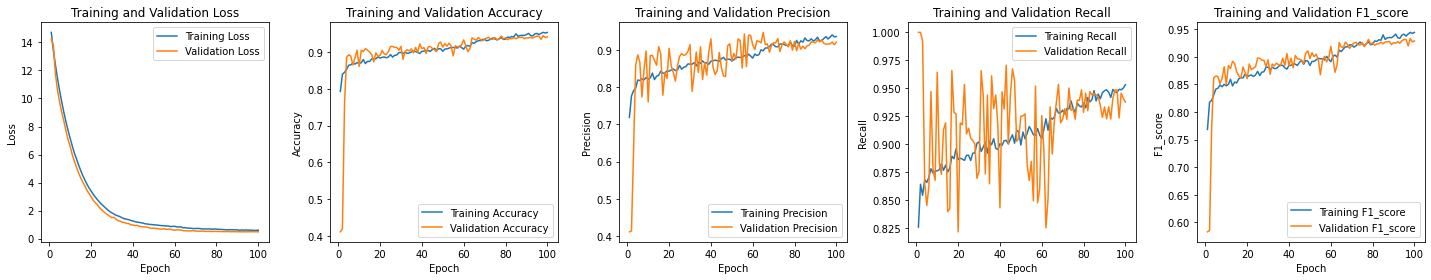

In [23]:
epochs_range = range(1, epochs + 1)
metrics = [key for key in history_binary.history.keys() if not key.startswith("val_") and not key.startswith("lr")]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, metric in enumerate(metrics):
    col = idx
    axes[col].plot(epochs_range, history_binary.history[metric], label=f'Training {metric.capitalize()}')
    axes[col].plot(epochs_range, history_binary.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
    axes[col].legend()
    axes[col].set_title(f'Training and Validation {metric.capitalize()}')
    axes[col].set_xlabel('Epoch')
    axes[col].set_ylabel(metric.capitalize())
plt.tight_layout()
plt.show()

评估不可见数据集的表现

In [88]:
model_binary.evaluate(test_isCancerous_generator)

62/62 [==============================] - 2s 27ms/step - loss: 0.5080 - accuracy: 0.9394 - precision: 0.9231 - recall: 0.9254 - f1_score: 0.9242


[0.5080224871635437,
 0.939393937587738,
 0.9230769276618958,
 0.9254108667373657,
 0.9242423176765442]

62/62 [==============================] - 0s 5ms/step


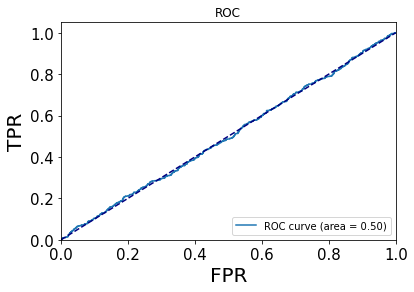

In [89]:
# y_true = test_isCancerous_generator.classes
# y_pred = model_binary.predict(test_isCancerous_generator)
# fpr, tpr, thresholds = roc_curve(y_true, y_pred)
# auc = roc_auc_score(y_true, y_pred)
#
# plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.xlabel('FPR', fontsize=20)
# plt.ylabel('TPR', fontsize=20)
# plt.title('ROC')
# plt.legend(loc="lower right")
# plt.show()

## 多分类卷积神经网络(改进模型)
在这个任务中，我们的目标仍然是预测细胞图像的分类。我们依旧是使用卷积神经网络（CNN）作为我们的改进模型。

正如我们在二分类改进模型中说的那样，通过正则化，dorpout层等技术来防止过拟合


由于任务是多分类，我们将使用categorical crossentropy函数作为我们的损失函数。

### Problem formulation
目标函数与多分类基线模型的目标函数一致。
但对于假设空间 $\mathcal{H}$，我们将假设空间 $\mathcal{H}$ 视为由所有可能的 CNN 模型（具有各种可能的参数、层数、卷积核大小和数量）构成的函数空间。

### 模型描述
多分类卷积神经网络模型结构与二分类卷积神经网络模型结构几乎一致。由于该任务为多分类任务我们将最后的输出层的激活函数从sigmoid函数改为softmax函数并且设置类别数量为4。

In [39]:
model_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model_categorical.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_41 (Bat  (None, 27, 27, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_42 (Bat  (None, 25, 25, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                      

In [40]:
model_categorical.compile(loss='categorical_crossentropy',
                          optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0003),
                          metrics=['accuracy',
                                   tf.keras.metrics.Precision(name='precision'),
                                   tf.keras.metrics.Recall(name='recall'),
                                   MultiCategoryF1Score()])

In [41]:
epochs = 100
history_categorical = model_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_cellType_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_cellType
    , callbacks=[lr_reducer]
)

Epoch 1/100
197/197 [==============================] - 13s 59ms/step - loss: 18.4458 - accuracy: 0.5065 - precision: 0.5467 - recall: 0.4503 - f1_score: 0.4660 - val_loss: 14.9264 - val_accuracy: 0.4107 - val_precision: 0.4107 - val_recall: 0.4107 - val_f1_score: 0.1456 - lr: 3.0000e-04
Epoch 2/100
197/197 [==============================] - 10s 52ms/step - loss: 16.9462 - accuracy: 0.5814 - precision: 0.6284 - recall: 0.5108 - f1_score: 0.5331 - val_loss: 13.5536 - val_accuracy: 0.5421 - val_precision: 0.5772 - val_recall: 0.5198 - val_f1_score: 0.4494 - lr: 3.0000e-04
Epoch 3/100
197/197 [==============================] - 10s 52ms/step - loss: 15.9054 - accuracy: 0.6117 - precision: 0.6645 - recall: 0.5314 - f1_score: 0.5634 - val_loss: 12.1115 - val_accuracy: 0.6901 - val_precision: 0.7525 - val_recall: 0.6129 - val_f1_score: 0.6524 - lr: 3.0000e-04
Epoch 4/100
197/197 [==============================] - 10s 49ms/step - loss: 14.8917 - accuracy: 0.6333 - precision: 0.6949 - recall: 0.

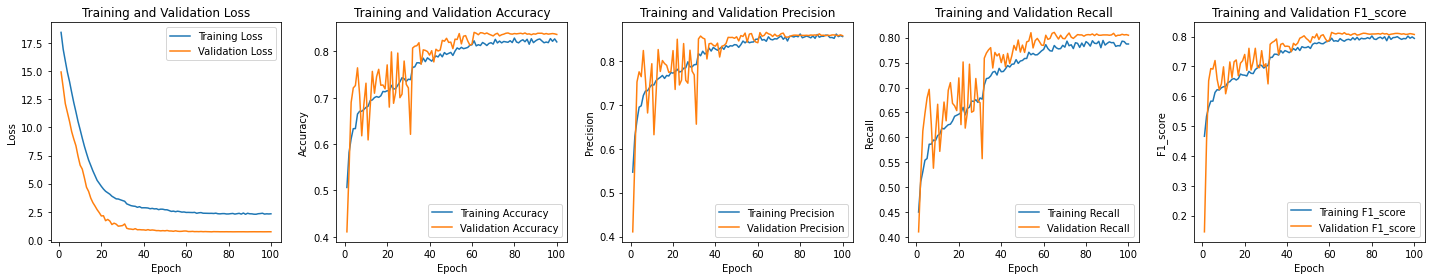

In [42]:
epochs_range = range(1, epochs + 1)
metrics = [key for key in history_categorical.history.keys() if not key.startswith("val_") and not key.startswith("lr")]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, metric in enumerate(metrics):
    col = idx
    axes[col].plot(epochs_range, history_categorical.history[metric], label=f'Training {metric.capitalize()}')
    axes[col].plot(epochs_range, history_categorical.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
    axes[col].legend()
    axes[col].set_title(f'Training and Validation {metric.capitalize()}')
    axes[col].set_xlabel('Epoch')
    axes[col].set_ylabel(metric.capitalize())
plt.tight_layout()
plt.show()

In [43]:
model_categorical.evaluate(test_cellType_generator)

62/62 [==============================] - 2s 32ms/step - loss: 0.7722 - accuracy: 0.8162 - precision: 0.8391 - recall: 0.7848 - f1_score: 0.7845


[0.7722386717796326,
 0.8161616325378418,
 0.8390928506851196,
 0.7848485112190247,
 0.7845267057418823]

In [44]:
model_categorical.save_weights('saved_model/model_categorical_weights')

# DI/HD 使用data_labels_extraData对多分类的模型进行增强

In [75]:
model_categorical.load_weights('saved_model/model_categorical_weights')

In [42]:
data_extra = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')
data_extra['isCancerous'] = data_extra['isCancerous'].astype(str)

In [43]:
binary_samples_isCancerous = data_extra['isCancerous'].value_counts()
total_samples = np.sum(binary_samples_isCancerous)
binary_weights_isCancerous = total_samples / binary_samples_isCancerous
binary_weight_dict_isCancerous = {int(k): v for k, v in binary_weights_isCancerous.to_dict().items()}

In [44]:
# 图片RandAugment增强
class RandAugmentGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, n, m, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rand_aug = iaa.RandAugment(n=n, m=m)

    def apply_transform(self, x, transform_parameters):
        x = x.numpy().astype(np.uint8)
        x_aug = self.rand_aug(image=x)
        x_aug = tf.convert_to_tensor(x_aug, dtype=tf.float64)
        return super().apply_transform(x_aug, transform_parameters)

重新生成新的train_generator

In [45]:
batch_size = 32
unlabeled_batch_size = len(data_extra) // len(train_data) * batch_size
unlabeled_datagen_weak = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
)

unlabeled_generator_weak = unlabeled_datagen_weak.flow_from_dataframe(
    data_extra,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=unlabeled_batch_size,
    class_mode='categorical'
)


unlabeled_datagen_strong = RandAugmentGenerator(
    n=4, m=6,
    rescale=1./255,
    fill_mode='nearest'
)

unlabeled_generator_strong = unlabeled_datagen_strong.flow_from_dataframe(
    data_extra,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=unlabeled_batch_size,
    class_mode='categorical'
)

Found 6332 validated image filenames belonging to 4 classes.
Found 10384 validated image filenames belonging to 2 classes.
Found 10384 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 4 classes.


## FixMatch 实现

### Problem formulation
对于我们使用的FixMatch方法，损失函数由三部分组成：有监督损失 $\(\ell_s\)$，非监督损失 $\(\ell_u\)$，以及特定于第二类别的损失 $\(\ell_{cat2}\)$。所以，我们的目标函数可以表示为以下方式。

$$\min_{h \in \mathcal{H}} \ell_s(h; \mathbf{x}_l, y_l) + \lambda \cdot \ell_u(h; \mathbf{x}_u) + \gamma \cdot \ell_{cat2}(h; \mathbf{x}_u)$$

这里，$\(\mathcal{H}\)$ 是假设空间，是所有可能的神经网络模型的集合。其中，$\(h\)$ 表示一个具体的模型；$\(\mathbf{x}_l, y_l\)$ 和 $\(\mathbf{x}_u\)$ 分别表示有标签的输入数据、有标签的输出数据和无标签的输入数据；$\(\lambda\)$ 和 $\(\gamma\)$ 是权衡不同损失之间重要性的超参数。

- 有监督损失 $\(\ell_s(h; \mathbf{x}_l, y_l)\)$ 是模型 $\(h\)$ 在有标签数据 $\((\mathbf{x}_l, y_l)\)$ 上的监督损失。

$$\ell_s=\frac{1}{B} \sum_{b=1}^B \mathrm{H}\left(p_b, p_{\mathrm{m}}\left(y \mid \alpha\left(x_b\right)\right)\right)$$

其中，$\(B\)$ 是批次大小，$\(p_b\)$ 是模型 $\(h\)$ 对于输入 $\(x_b\)$ 的预测概率分布，$\(p_{\mathrm{m}}\)$ 是真实标签 $\(y\)$ 对应的概率分布，$\(\alpha\)$ 是数据增强函数，$\(\mathrm{H}\)$ 是交叉熵损失。

- 非监督损失 $\(\ell_u(h; \mathbf{x}_u)\)$ 是模型 $\(h\)$ 在无标签数据 $\(\mathbf{x}_u\)$ 上的非监督损失，其中 $\(\mathbf{x}_u\)$ 的伪标签是由模型 $\(h\)$ 自身生成的。

$$\ell_{u}=\frac{1}{B} \sum_{b=1}^{B} \mathbb{1}\left(\max \left(p_b\right) \geq \tau\right) \mathbb{1}\left(y_{b} \neq 2\right) \mathrm{H}\left(\hat{q}_b, p_{\mathrm{m}}\left(y \mid \mathcal{A}\left(u_b\right)\right)\right)$$

其中，$\(q_b\)$ 是模型 $\(h\)$ 对于输入 $\(u_b\)$ 的预测概率分布，$\(\hat{q}_b\)$ 是 $\(q_b\)$ 对应的伪标签的概率分布，$\(\mathcal{A}\)$ 是更强的数据增强函数，$\(\tau\)$ 是置信度阈值，只有当模型对某个类别的预测概率大于 $\(\tau\)$ 时，才会计算该无标签样本的非监督损失。$\(y_{b}\)$ 是实际的类别，如果类别不等于2，则为1，否则为0。 $\(\mathbb{1}\left(y_{b} \neq 2\right)\)$ 是一个指示函数，只有当实际类别不等于2时，才会对该样本的一致性损失进行计算。这样，我们可以确保一致性损失主要关注其他类别的一致性，而忽略了类别2。


- 特定于第二类别的损失 $\(\ell_{cat2}(h; \mathbf{x}_u)\)$ 是模型 $\(h\)$ 在无标签数据 $\(\mathbf{x}_u\)$ 上对第二类别的预测误差，用来强调第二类别的重要性。

$$\ell_{cat2}=\frac{1}{B} \sum_{b=1}^{B} \mathbb{1}\left(y_{b} = 2 \lor \hat{y}_{b} = 2\right) \mathrm{L}\left(y_{b}, p_{\mathrm{m}}\left(y \mid \mathcal{A}\left(u_b\right)\right)\right)$$

其中，$\(y_{b}\)$ 是实际的类别，如果类别等于2，则为1，否则为0。 $\(\hat{y}_{b}\)$ 是伪标签，如果伪标签等于2，则为1，否则为0。 $\(\mathbb{1}\left(y_{b} = 2 \lor \hat{y}_{b} = 2\right)\)$ 是一个指示函数，当实际类别或伪标签等于2时，该函数为1，否则为0。这样，当实际类别或伪标签等于2时，我们就会对该样本的损失进行计算。这是为了特别惩罚模型在预测类别2时的错误，$\(\mathrm{L}\)$ 是二元交叉熵损失函数。

在这种情况下，我们对预测为2的样本或者实际为2的样本增加了权重，这有助于模型在预测类别2时更加准确。这就是我们为什么要引入类别2损失的原因。

通过优化这个目标函数，我们能够在有标签数据上进行监督学习，同时在无标签数据上进行自监督学习，从而充分利用数据，提高模型的性能。同时，对第二类别的特殊处理也使得模型在预测第二类别时更加准确。

In [46]:
def apply_fixmatch(x, y_true, x_unlabeled, cancer_mask, model, optimizer, training=True, class_weight_dict=None, cancer_weight_dict=None, consistency_weight=0.1, category_2_weight=1, confidence_threshold=0.95):
    with tf.GradientTape() as tape:
        y_pred_labeled = model(x)
        # 计算有监督损失
        # 如果是训练并且给定了类别权重，则根据权重计算损失。
        if class_weight_dict is not None and training:
            class_weight_tensor = tf.constant([class_weight_dict[0], class_weight_dict[1], class_weight_dict[2], class_weight_dict[3]])
            sample_weights = tf.gather(class_weight_tensor, tf.argmax(y_true, axis=-1))
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred_labeled) * sample_weights)
        else:
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred_labeled))
        final_loss = supervised_loss

        # 计算模型在原始无标签数据和增强无标签数据上的输出
        if x_unlabeled is not None:
            # 对无标签数据进行数据增强
            y_pred_unlabeled_weak = model(x_unlabeled[0])
            y_pred_unlabeled_strong = model(x_unlabeled[1])
            # 计算伪标签
            pseudo_labels = tf.argmax(y_pred_unlabeled_weak, axis=-1)
            # 计算最大概率
            max_probs = tf.reduce_max(y_pred_unlabeled_weak, axis=-1)
            # Confidence-based masking 基于置信度的掩码
            mask = max_probs > confidence_threshold
            # 定义癌症样本和非癌症样本的掩码
            cancer_mask = (cancer_mask[:, 1] == 1)
            non_cancer_mask = tf.math.logical_not(cancer_mask)
            # 计算与预测为2相关的样本的掩码
            pred_2_mask = tf.equal(pseudo_labels, 2)
            not_pred_2_mask = tf.math.logical_not(pred_2_mask)
            # 计算一致性损失的掩码
            # 预测为2但实际不为2
            loss_mask_1 = tf.math.logical_and(pred_2_mask, non_cancer_mask)
            # 预测不为2但实际为2
            loss_mask_2 = tf.math.logical_and(not_pred_2_mask, cancer_mask)
            category_2_loss_mask = tf.math.logical_or(loss_mask_1, loss_mask_2)
            remaining_mask = tf.math.logical_and(mask, tf.math.logical_not(category_2_loss_mask))
            # 计算一致性损失
            pseudo_labels_one_hot = tf.one_hot(pseudo_labels, depth=tf.shape(y_pred_unlabeled_weak)[-1])
            per_example_loss = tf.keras.losses.categorical_crossentropy(pseudo_labels_one_hot, y_pred_unlabeled_strong)
            consistency_loss = tf.reduce_sum(per_example_loss * tf.cast(remaining_mask, per_example_loss.dtype)) / tf.reduce_sum(tf.cast(remaining_mask, tf.float32) + tf.keras.backend.epsilon())
            # 计算 category_2_loss
            binary_labels = tf.cast(cancer_mask, dtype=tf.float32)
            category_2_per_example_loss = tf.keras.losses.binary_crossentropy(binary_labels, y_pred_unlabeled_weak[:, 2])
            if cancer_weight_dict is not None:
                weights = tf.where(cancer_mask, cancer_weight_dict[0], cancer_weight_dict[1])
                category_2_per_example_loss *= weights
            category_2_loss = tf.reduce_sum(category_2_per_example_loss * tf.cast(category_2_loss_mask, category_2_per_example_loss.dtype)) / tf.reduce_sum(tf.cast(category_2_loss_mask, tf.float32) + tf.keras.backend.epsilon())

            final_loss = final_loss + consistency_weight * consistency_loss + category_2_weight * category_2_loss

        # 计算准确度
        accuracy = tf.keras.metrics.CategoricalAccuracy()
        accuracy.update_state(y_true, y_pred_labeled)

        if training:
            # 反向传播和优化
            grads = tape.gradient(final_loss, model_categorical.trainable_variables)
            optimizer.apply_gradients(zip(grads, model_categorical.trainable_variables))

    return {"loss": final_loss,
            "supervised_loss": supervised_loss,
            "consistency_loss" :consistency_loss if x_unlabeled is not None else None,
            "category_2_loss": category_2_loss if x_unlabeled is not None else None,
            "accuracy": accuracy.result()}

In [48]:
adam = tf.keras.optimizers.legacy.Adam(learning_rate=3e-8)
epochs = 3
min_val_loss = float('inf')
num_epochs_no_improvement = 0
current_learning_rate = adam.learning_rate.numpy()
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": [], "precision":[],
           "recall":[], "f1":[], "val_precision":[], "val_recall":[], "val_f1":[]}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    total_loss = 0
    total_supervised_loss = 0
    total_consistency_loss = 0
    total_category_2_loss = 0
    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    total_f1_score = 0
    steps = 0

    total_batches = math.ceil(len(train_data) / batch_size)
    with tqdm(total=total_batches, desc="Training", ncols=100) as progress_bar:
        for (x_batch, y_batch), (x_unlabeled_weak, y_binary), (x_unlabeled_strong, _) in zip(train_cellType_generator, unlabeled_generator_weak, unlabeled_generator_strong):
            progress_bar.update(1)
            result = apply_fixmatch(x_batch, y_batch, (x_unlabeled_weak, x_unlabeled_strong),
                                    y_binary, model_categorical, adam)
            total_loss += result["loss"]
            total_supervised_loss += result["supervised_loss"]
            total_consistency_loss += result["consistency_loss"]
            total_category_2_loss += result["category_2_loss"]
            total_accuracy += result["accuracy"]
            steps += 1
            # 检查是否已经处理了所有批次
            if steps * batch_size >= len(train_data):
                break

        # 计算并打印平均损失和准确率
        avg_loss = total_loss / steps
        avg_supervised_loss = total_supervised_loss / steps
        avg_consistency_loss = total_consistency_loss / steps
        avg_category_2_loss = total_category_2_loss / steps
        avg_accuracy = total_accuracy / steps

        history["loss"].append(avg_loss.numpy())
        history["accuracy"].append(avg_accuracy.numpy())
        print(f" - loss: {avg_loss.numpy():.4f}, supervised_loss: {avg_supervised_loss.numpy():.4f}, consistency_loss: {avg_consistency_loss.numpy():.4f}, category_2_loss: {avg_category_2_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}")

    total_loss = 0
    total_accuracy = 0
    total_recall = 0
    total_precision = 0
    total_f1_score = 0
    steps = 0
    for x_batch, y_batch in val_cellType_generator:
        result = apply_fixmatch(x_batch, y_batch, None, None, model_categorical, adam, False)
        total_loss += result["loss"]
        total_accuracy += result["accuracy"]
        steps += 1

        if steps * batch_size >= len(test_data):
            break

    avg_loss = total_loss / steps
    avg_accuracy = total_accuracy / steps

    history["val_loss"].append(avg_loss)
    history["val_accuracy"].append(avg_accuracy.numpy())

    print(f"Validation set： - loss: {avg_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}， lr: {current_learning_rate:.2e}")

    # 检查是否需要更新学习率
    if avg_loss < min_val_loss:
        min_val_loss = avg_loss
        num_epochs_no_improvement = 0
    else:
        current_learning_rate *= np.sqrt(0.1)
        current_learning_rate = max(current_learning_rate, 0.5e-15)
        adam.learning_rate.assign(current_learning_rate)
        num_epochs_no_improvement = 0

Epoch 1/3


Training:   0%|                                                             | 0/198 [00:00<?, ?it/s]/Users/hueybai/miniconda3/envs/DL/lib/python3.10/site-packages/imgaug/augmenters/meta.py:3368: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  augmenter_active = np.zeros((nb_rows, len(self)), dtype=np.bool)
Training:   0%|                                                             | 0/198 [00:00<?, ?it/s]


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [77]:
model_categorical.evaluate(test_cellType_generator)

62/62 [==============================] - 3s 46ms/step - loss: 1.9885 - accuracy: 0.8303 - precision: 0.8557 - recall: 0.8086 - f1_score: 0.8066


[1.988533616065979,
 0.8303030133247375,
 0.8556921482086182,
 0.8085858821868896,
 0.8066039681434631]